# Vibe Matcher — Prototype Notebook

This notebook implements a tiny recommendation system that matches a user's *vibe* query
to fashion product descriptions using vector similarity.

**Features included**
- Mock product dataset (5–10 items) with `name`, `desc`, and `vibes` tags.
- Embeddings via OpenAI API (text-embedding-ada-002) **or** fallback to TF-IDF vectors if no API key.
- Cosine similarity search (scikit-learn) to return the top-3 matches with scores.
- Test harness (3 queries), simple evaluation (score > 0.7 considered "good"), and latency timing.
- Plots for score distributions and query latencies.
- Short reflection & suggested improvements.

> Notes: To use OpenAI embeddings, set the environment variable `OPENAI_API_KEY` or paste your key in the indicated cell.


In [22]:
# Install requirements (uncomment if running in Colab)
!pip install openai scikit-learn pandas matplotlib tqdm nbformat


In [23]:
# --- Data Prep ---
import pandas as pd

products = [
    {"name": "Boho Dress", "desc": "Flowy linen maxi with earthy tones, tassels, and floral embroidery — festival-ready bohemian vibes.", "vibes": ["boho", "festival", "earthy"]},
    {"name": "Urban Blazer", "desc": "Structured blazer with subtle sheen, cropped cut and utility pockets — energetic urban chic for city nights.", "vibes": ["urban", "chic", "energetic"]},
    {"name": "Cozy Knit Pullover", "desc": "Chunky knit, oversized fit, soft wool blend — perfect for relaxed, cozy weekends.", "vibes": ["cozy", "casual", "warm"]},
    {"name": "Minimal Slip Dress", "desc": "Satin slip dress with clean lines — minimal, elegant, evening-ready.", "vibes": ["minimal", "elegant", "evening"]},
    {"name": "Sporty Runner", "desc": "Breathable stretch fabric with reflective accents — energetic and active street-sport style.", "vibes": ["sporty", "energetic", "active"]},
    {"name": "Vintage Denim Jacket", "desc": "Distressed denim with embroidered patches — retro-casual with a rebellious twist.", "vibes": ["vintage", "casual", "retro"]},
    {"name": "Preppy Cardigan", "desc": "Crisp knit with contrast trim and mother-of-pearl buttons — polished, preppy daytime look.", "vibes": ["preppy", "polished", "daytime"]},
    {"name": "Glam Sequin Top", "desc": "High-shine sequins, cropped silhouette — party-glam and attention-grabbing.", "vibes": ["glam", "party", "bold"]},
]

df = pd.DataFrame(products)
df.index.name = "id"
df


,name,desc,vibes
id,,,
0,Boho Dress,"Flowy linen maxi with earthy tones, tassels, a...","[boho, festival, earthy]"
1,Urban Blazer,"Structured blazer with subtle sheen, cropped c...","[urban, chic, energetic]"
2,Cozy Knit Pullover,"Chunky knit, oversized fit, soft wool blend — ...","[cozy, casual, warm]"
3,Minimal Slip Dress,"Satin slip dress with clean lines — minimal, e...","[minimal, elegant, evening]"
4,Sporty Runner,Breathable stretch fabric with reflective acce...,"[sporty, energetic, active]"
5,Vintage Denim Jacket,Distressed denim with embroidered patches — re...,"[vintage, casual, retro]"
6,Preppy Cardigan,Crisp knit with contrast trim and mother-of-pe...,"[preppy, polished, daytime]"
7,Glam Sequin Top,"High-shine sequins, cropped silhouette — party...","[glam, party, bold]"


In [24]:
# --- Embeddings: OpenAI (preferred) or TF-IDF fallback ---
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer here

USE_OPENAI = False
try:
    import openai
    key = os.environ.get("OPENAI_API_KEY")
    if key:
        openai.api_key = key
        USE_OPENAI = True
    else:
        USE_OPENAI = False
except Exception:
    USE_OPENAI = False

print("Using OpenAI embeddings?", USE_OPENAI)

def get_openai_embeddings(texts, model="text-embedding-ada-002", batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        resp = openai.Embedding.create(input=batch, model=model)
        for item in resp['data']:
            embeddings.append(item['embedding'])
    return embeddings

# Global TF-IDF vectorizer instance
tfidf_vectorizer_instance = None

def embed_texts(texts, fit_vectorizer=False):
    global tfidf_vectorizer_instance # Declare intent to modify global variable

    if USE_OPENAI:
        return np.array(get_openai_embeddings(texts))
    else:
        if tfidf_vectorizer_instance is None or fit_vectorizer:
            # Initialize and fit TF-IDF vectorizer if not already done or explicitly requested
            tfidf_vectorizer_instance = TfidfVectorizer(max_features=512, stop_words='english')
            vecs = tfidf_vectorizer_instance.fit_transform(texts)
        else:
            # Use already fitted TF-IDF vectorizer to transform new texts
            vecs = tfidf_vectorizer_instance.transform(texts)
        return np.array(vecs.toarray())

product_texts = df['desc'].tolist()
# First call to embed_texts, fit the TF-IDF vectorizer on product descriptions
product_embeddings = embed_texts(product_texts, fit_vectorizer=True)
print("Product embeddings shape:", product_embeddings.shape)

Using OpenAI embeddings? False
Product embeddings shape: (8, 79)


In [25]:
# --- Vector Search (cosine similarity) ---
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def top_k_matches(query, k=3):
    if hasattr(embed_texts, "tfidf_vectorizer"):
        # Use the existing fitted TF-IDF vectorizer
        q_vec = embed_texts.tfidf_vectorizer.transform([query]).toarray()[0]
    else:
        # For OpenAI embedding mode
        q_vec = embed_texts([query])[0]

    sims = cosine_similarity([q_vec], product_embeddings)[0]
    idxs = np.argsort(sims)[::-1][:k]
    results = []
    for i in idxs:
        results.append({"id": int(i), "name": df.iloc[i]['name'], "desc": df.iloc[i]['desc'], "vibes": df.iloc[i]['vibes'], "score": float(sims[i])})
    return results

query = "energetic urban chic"
print("Query:", query)
matches = top_k_matches(query, k=3)
for r in matches:
    print(f"- {r['name']} (score: {r['score']:.4f}) — vibes: {r['vibes']}")


Query: energetic urban chic
- Urban Blazer (score: 0.4667) — vibes: ['urban', 'chic', 'energetic']
- Sporty Runner (score: 0.1372) — vibes: ['sporty', 'energetic', 'active']
- Preppy Cardigan (score: 0.0000) — vibes: ['preppy', 'polished', 'daytime']


In [29]:
# --- Test & Evaluation ---
import time
from statistics import mean

queries = [
    "energetic urban chic",
    "relaxed cozy weekend",
    "party glam night out",
]

results_log = []
latencies = []

for q in queries:
    t0 = time.perf_counter()
    res = top_k_matches(q, k=3)
    t1 = time.perf_counter()
    latency = (t1 - t0)
    latencies.append(latency)
    top_score = res[0]['score']
    good = top_score > 0.7
    results_log.append({"query": q, "top_score": top_score, "good": good, "latency_s": latency, "results": res})

for entry in results_log:
    print(f"Query: {entry['query']}\n  top_score: {entry['top_score']:.4f}  good: {entry['good']}  latency_s: {entry['latency_s']:.4f}")
    for r in entry['results']:
        print(f"    - {r['name']} (score={r['score']:.4f})")
    print()

print('Average latency (s):', mean(latencies))


Query: energetic urban chic
  top_score: 0.4667  good: False  latency_s: 0.0052
    - Urban Blazer (score=0.4667)
    - Sporty Runner (score=0.1372)
    - Preppy Cardigan (score=0.0000)

Query: relaxed cozy weekend
  top_score: 0.4323  good: False  latency_s: 0.0043
    - Cozy Knit Pullover (score=0.4323)
    - Glam Sequin Top (score=0.0000)
    - Vintage Denim Jacket (score=0.0000)

Query: party glam night out
  top_score: 0.4794  good: False  latency_s: 0.0064
    - Glam Sequin Top (score=0.4794)
    - Preppy Cardigan (score=0.0000)
    - Vintage Denim Jacket (score=0.0000)

Average latency (s): 0.005320993666676562


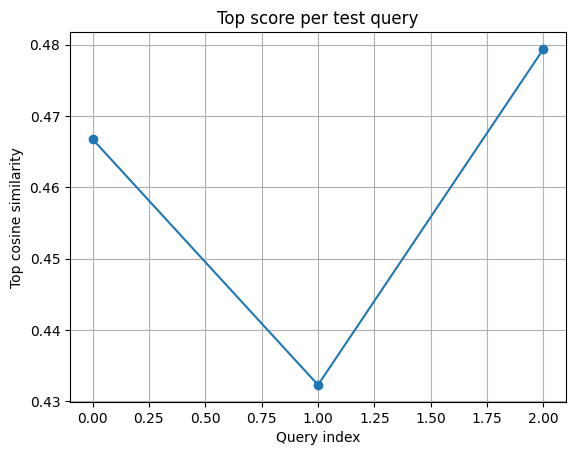

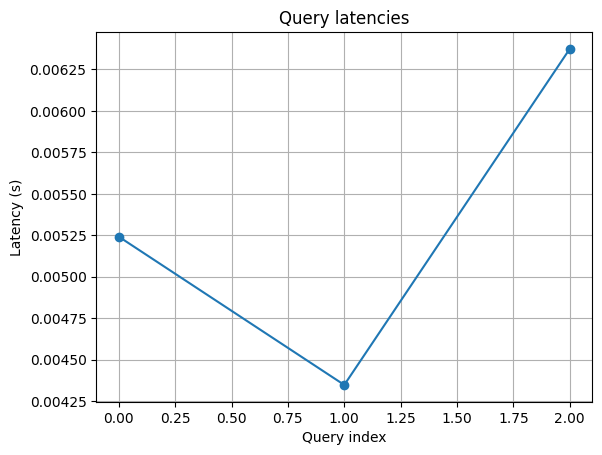

In [30]:
# --- Plots: Score distribution and latency ---
import matplotlib.pyplot as plt

top_scores = [entry['top_score'] for entry in results_log]

plt.figure()
plt.title("Top score per test query")
plt.xlabel("Query index")
plt.ylabel("Top cosine similarity")
plt.plot(range(len(top_scores)), top_scores, marker='o')
plt.grid(True)
plt.show()

plt.figure()
plt.title("Query latencies")
plt.xlabel("Query index")
plt.ylabel("Latency (s)")
plt.plot(range(len(latencies)), latencies, marker='o')
plt.grid(True)
plt.show()


In [31]:
# --- Edge handling & fallback prompt ---
def fallback_prompt(query):
    return f"""I couldn't find strong matches for '{query}'.\n\nPlease provide a short list (3) of vibe keywords or styles you'd like to emphasize (e.g., 'boho, earthy, festival') so I can expand the search."""

for entry in results_log:
    if entry['top_score'] < 0.4:
        print('Low-confidence match for query:', entry['query'])
        print('Suggested fallback prompt to user:')
        print(fallback_prompt(entry['query']))
        print()
